<a href="https://www.kaggle.com/code/dataranch/data-science-pay-feature-importance-28-models?scriptVersionId=106919465" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# <div style="text-align: center; background-color: blue; color: white; padding: 14px; line-height: 1;border-radius:20px">**Data Science Salaries Model Comparison + Feature Importance 📊**</div>
- Preprocessing
    - Detect continuous and categorical variables.
    - Normalize and impute data.
    

- For every target variable in the dataset:
    - Compare performance on 27 models + a TabNet model.
    - Output model performance and processed data in CSV format for every dataset.
    - Save plots + CSVs of XGBoost Feature Importances.
    - Save best performing FastAI model.

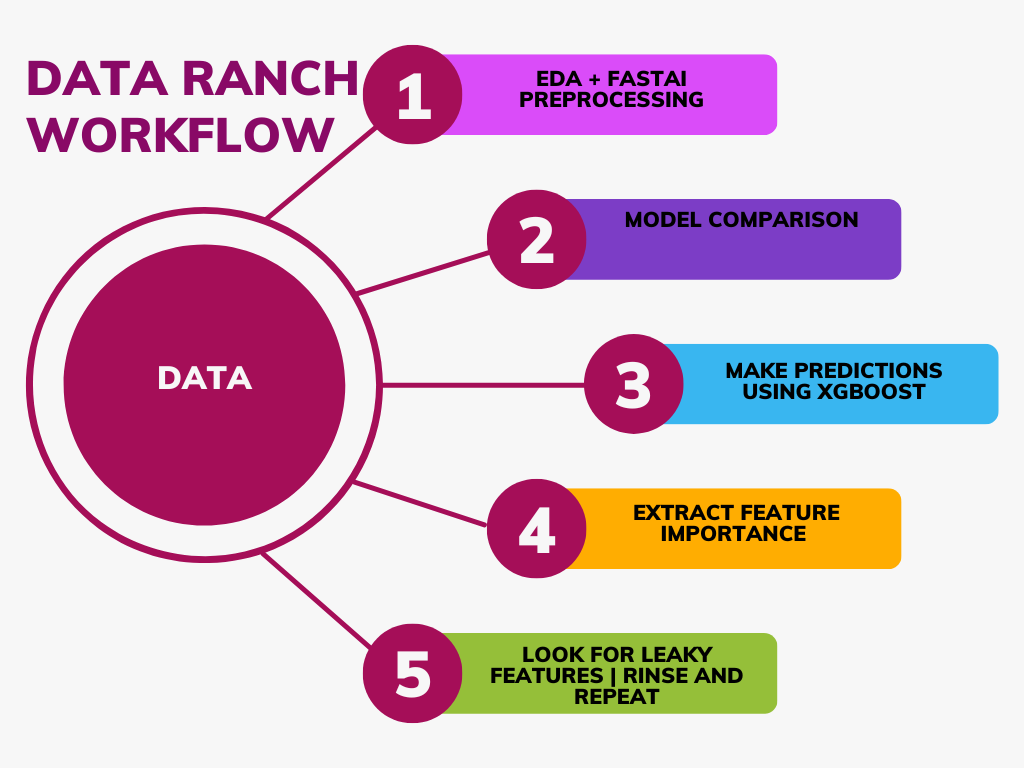

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install lazypredict

In [3]:
!pip install --upgrade pandas

In [4]:
!pip install fast-tabnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 932.8 kB/s eta 0:00:00


In [5]:
!pip install fastai

  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.3.0
    Uninstalling typing_extensions-4.3.0:
      Successfully uninstalled typing_extensions-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
tensorflow 2.6.4 requires h5py~=3.1.0, but you have h5py 3.7.0 which is incompatible.
tensorflow 2.6.4 requires numpy~=1.19.2, but you have numpy 1.21.6 which is incompatible.
tensorflow 2.6.4 requires tensorboard<2.7,>=2.6.0, but you have tensorboard 2.10.0 which is incompatible.
tensorflow 2.6.4 requires typing-extensions<3.11,>=3.7, but you have typing-extensions 4.1.1 which is incompatible.
tensorflow-transform 1.9.0 requires pyarrow<6,>=1, but you have pyarrow 8.0.0 which is incompatible.
tensorflow-transform 1.9.0 requires te

In [6]:
!pip install pandas-profiling

  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 2.1.1
    Uninstalling MarkupSafe-2.1.1:
      Successfully uninstalled MarkupSafe-2.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
werkzeug 2.2.2 requires MarkupSafe>=2.1.1, but you have markupsafe 2.0.1 which is incompatible.


In [7]:
#A program that takes a csv and trains models on it. Streamlined model selection.
#==============================================================================

#LazyPredict
import lazypredict
from lazypredict.Supervised import LazyRegressor
from lazypredict.Supervised import LazyClassifier
#Baysian Optimization
from bayes_opt import BayesianOptimization
#Pandas stack
import pandas as pd
import pandas_profiling
import numpy as np
#FastAI
from fastai.tabular.all import *
from fastai.tabular.core import *
#Plots
import matplotlib.pyplot as plt
import seaborn as sns
#System
import os
import sys
import traceback
#Fit an xgboost model
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
#Random
import random

#TabNet
from fast_tabnet.core import *

import shutil

In [8]:
%matplotlib inline

In [9]:
#Project Variables
#===================================================================================================
PROJECT_NAME = 'data-science-job-salaries'
VARIABLE_FILES = False
#Maximum amount of rows to take
SAMPLE_COUNT = 20000
FASTAI_LEARNING_RATE = 1e-1
AUTO_ADJUST_LEARNING_RATE = False
#Set to True automatically infer if variables are categorical or continuous
ENABLE_BREAKPOINT = True
#When trying to declare a column a continuous variable, if it fails, convert it to a categorical variable
CONVERT_TO_CAT = False
REGRESSOR = True
SEP_DOLLAR = True
SEP_PERCENT = True
SHUFFLE_DATA = True

In [10]:
input_dir = f'../input/{PROJECT_NAME}'
param_dir = f'/kaggle/working/{PROJECT_NAME}'
TARGET = ''
PARAM_DIR = param_dir
print(f'param_dir: {param_dir}')
if not os.path.exists(param_dir):
    os.makedirs(param_dir)
#rename any file in param_dir/file that ends with csv to data.csv
for file in os.listdir(input_dir):
    if file.endswith('.csv'):
        print('CSV!')
        if 'classification_results' not in file and 'regression_results' not in file:
            #os.rename(f'{input_dir}/{file}', f'{param_dir}/data.csv')
            shutil.copy(f'{input_dir}/{file}', f'{param_dir}/data.csv')
        #os.rename(f'{param_dir}/{file}', f'{param_dir}/data.csv')
try:
    df = pd.read_csv(f'{param_dir}/data.csv', nrows=SAMPLE_COUNT)
except:
    print(f'Please place a file named data.csv in {param_dir}')
    #sys.exit()

param_dir: /kaggle/working/data-science-job-salaries
CSV!


In [11]:
df

,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L
...,...,...,...,...,...,...,...,...,...,...,...,...
602,602,2022,SE,FT,Data Engineer,154000,USD,154000,US,100,US,M
603,603,2022,SE,FT,Data Engineer,126000,USD,126000,US,100,US,M
604,604,2022,SE,FT,Data Analyst,129000,USD,129000,US,0,US,M
605,605,2022,SE,FT,Data Analyst,150000,USD,150000,US,100,US,M


In [12]:
df.isna().sum()

Unnamed: 0            0
work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64

In [13]:
df.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

<AxesSubplot:>

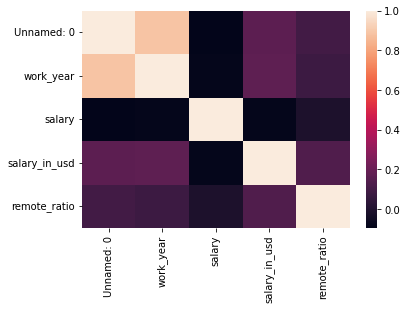

In [14]:
sns.heatmap(df.corr())

In [15]:
df.head().style.background_gradient(cmap = "inferno")

,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


In [16]:
df.describe().T.style.background_gradient(cmap = "viridis")

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,607.00,303.00,175.37,0.00,151.50,303.00,454.50,606.00
work_year,607.00,2021.41,0.69,2020.00,2021.00,2022.00,2022.00,2022.00
salary,607.00,324000.06,1544357.49,4000.00,70000.00,115000.00,165000.00,30400000.00
salary_in_usd,607.00,112297.87,70957.26,2859.00,62726.00,101570.00,150000.00,600000.00
remote_ratio,607.00,70.92,40.71,0.00,50.00,100.00,100.00,100.00


In [17]:
df.columns

Index(['Unnamed: 0', 'work_year', 'experience_level', 'employment_type',
       'job_title', 'salary', 'salary_currency', 'salary_in_usd',
       'employee_residence', 'remote_ratio', 'company_location',
       'company_size'],
      dtype='object')

In [18]:
#remove 'Unnamed:0' as it's a leaky feature
del(df['Unnamed: 0'])

Target Variable: remote_ratio
CATS=====================
['work_year', 'experience_level', 'employment_type', 'salary_currency', 'remote_ratio', 'company_size']
CONTS=====================
['job_title', 'salary', 'salary_in_usd', 'employee_residence', 'company_location']
11
Could not convert job_title to float.
Could not convert employee_residence to float.
Could not convert company_location to float.
Looping through continuous variables to find breakpoint
Error with  job_title
Error with  employee_residence
Error with  company_location
Continuous variables that made the cut : ['salary', 'salary_in_usd']
Categorical variables that made the cut : ['work_year', 'experience_level', 'employment_type', 'salary_currency', 'remote_ratio', 'company_size']
Tabular Object size: 565


 14%|█▍        | 6/42 [00:00<00:00, 56.82it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': -0.018907040858945345, 'Adjusted R-Squared': -0.06651951940375578, 'RMSE': 0.7240549433590547, 'Time taken': 0.01844024658203125}
{'Model': 'BaggingRegressor', 'R-Squared': -0.09816422519522461, 'Adjusted R-Squared': -0.14948031048472088, 'RMSE': 0.751688467179214, 'Time taken': 0.0284426212310791}
{'Model': 'BayesianRidge', 'R-Squared': -0.010351145144688267, 'Adjusted R-Squared': -0.05756381547855205, 'RMSE': 0.7210085425807918, 'Time taken': 0.027896881103515625}
{'Model': 'DecisionTreeRegressor', 'R-Squared': -0.3601099793264402, 'Adjusted R-Squared': -0.4236665204164607, 'RMSE': 0.836548750463384, 'Time taken': 0.010032892227172852}
{'Model': 'DummyRegressor', 'R-Squared': -0.015220700152207112, 'Adjusted R-Squared': -0.06266091978548771, 'RMSE': 0.722743964215767, 'Time taken': 0.008895397186279297}
{'Model': 'ElasticNet', 'R-Squared': -0.015220700152207112, 'Adjusted R-Squared': -0.06266091978548771, 'RMSE': 0.722743964215767, 'Time ta

 29%|██▊       | 12/42 [00:00<00:01, 21.78it/s]

{'Model': 'GaussianProcessRegressor', 'R-Squared': -1.0360374282965297, 'Adjusted R-Squared': -1.1311793641982364, 'RMSE': 1.0235218537927455, 'Time taken': 0.06368613243103027}
{'Model': 'GradientBoostingRegressor', 'R-Squared': -0.060507365376406774, 'Adjusted R-Squared': -0.11006378431922936, 'RMSE': 0.7386880712509348, 'Time taken': 0.1123955249786377}


 45%|████▌     | 19/42 [00:00<00:01, 20.03it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.020386619895840674, 'Adjusted R-Squared': -0.02538970627725079, 'RMSE': 0.7099562641729968, 'Time taken': 0.1940000057220459}
{'Model': 'HuberRegressor', 'R-Squared': -0.03525445076129219, 'Adjusted R-Squared': -0.08363082696509072, 'RMSE': 0.7298402228173061, 'Time taken': 0.016504764556884766}
{'Model': 'KNeighborsRegressor', 'R-Squared': -0.17162252663622524, 'Adjusted R-Squared': -0.22637124283417953, 'RMSE': 0.7764224741769649, 'Time taken': 0.011037826538085938}
{'Model': 'KernelRidge', 'R-Squared': -12.122237462397797, 'Adjusted R-Squared': -12.735426128864981, 'RMSE': 2.598413043158839, 'Time taken': 0.042893171310424805}
{'Model': 'Lars', 'R-Squared': -0.030151272198488677, 'Adjusted R-Squared': -0.07828918211430569, 'RMSE': 0.7280391650127566, 'Time taken': 0.043274641036987305}
{'Model': 'LarsCV', 'R-Squared': -0.002571897887168939, 'Adjusted R-Squared': -0.049421051994045895, 'RMSE': 0.7182274589814074, 'Time taken':

 55%|█████▍    | 23/42 [00:01<00:00, 23.68it/s]

{'Model': 'LassoCV', 'R-Squared': -0.00810949431537189, 'Adjusted R-Squared': -0.055217414610482685, 'RMSE': 0.7202082530536719, 'Time taken': 0.06565165519714355}
{'Model': 'LassoLars', 'R-Squared': -0.015220700152207112, 'Adjusted R-Squared': -0.06266091978548771, 'RMSE': 0.722743964215767, 'Time taken': 0.01072835922241211}
{'Model': 'LassoLarsCV', 'R-Squared': -0.002571897887168939, 'Adjusted R-Squared': -0.049421051994045895, 'RMSE': 0.7182274589814074, 'Time taken': 0.019908666610717773}
{'Model': 'LassoLarsIC', 'R-Squared': -0.0021265621296415738, 'Adjusted R-Squared': -0.04895490615439102, 'RMSE': 0.7180679253374063, 'Time taken': 0.012411355972290039}
{'Model': 'LinearRegression', 'R-Squared': -0.030151272198488455, 'Adjusted R-Squared': -0.07828918211430547, 'RMSE': 0.7280391650127565, 'Time taken': 0.011281490325927734}
{'Model': 'LinearSVR', 'R-Squared': -0.2192268223174254, 'Adjusted R-Squared': -0.27620003831356654, 'RMSE': 0.7920388699496506, 'Time taken': 0.012282371520

 69%|██████▉   | 29/42 [00:02<00:01,  9.83it/s]

{'Model': 'MLPRegressor', 'R-Squared': -0.07087485929344095, 'Adjusted R-Squared': -0.12091574056883525, 'RMSE': 0.7422899878060955, 'Time taken': 1.0227296352386475}
{'Model': 'NuSVR', 'R-Squared': 0.01229106048885864, 'Adjusted R-Squared': -0.03386356285278347, 'RMSE': 0.7128837801049602, 'Time taken': 0.06658291816711426}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': -0.006764460501237579, 'Adjusted R-Squared': -0.053809528748958835, 'RMSE': 0.7197276367170853, 'Time taken': 0.021396398544311523}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': -0.006764460501237579, 'Adjusted R-Squared': -0.053809528748958835, 'RMSE': 0.7197276367170853, 'Time taken': 0.031311750411987305}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -4.121718925035994, 'Adjusted R-Squared': -4.361051585084405, 'RMSE': 1.6233498000676827, 'Time taken': 0.013700723648071289}
{'Model': 'PoissonRegressor', 'R-Squared': -0.01450795959186646, 'Adjusted R-Squared': -0.061914873591486286, 'RMSE': 0.7224

 76%|███████▌  | 32/42 [00:04<00:03,  2.99it/s]

{'Model': 'QuantileRegressor', 'R-Squared': -0.5479452054051828, 'Adjusted R-Squared': -0.6202790935082285, 'RMSE': 0.892446175941685, 'Time taken': 2.7301390171051025}
{'Model': 'RANSACRegressor', 'R-Squared': -0.547945205479452, 'Adjusted R-Squared': -0.6202790935859683, 'RMSE': 0.8924461759630944, 'Time taken': 0.1361837387084961}


 81%|████████  | 34/42 [00:05<00:02,  3.38it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': -0.0964624069828699, 'Adjusted R-Squared': -0.1476989680568357, 'RMSE': 0.7511057979003712, 'Time taken': 0.16595053672790527}
{'Model': 'Ridge', 'R-Squared': -0.03000741751063085, 'Adjusted R-Squared': -0.07813860524477234, 'RMSE': 0.7279883300013301, 'Time taken': 0.011943817138671875}
{'Model': 'RidgeCV', 'R-Squared': -0.028761157005775306, 'Adjusted R-Squared': -0.0768341082677273, 'RMSE': 0.7275477808893449, 'Time taken': 0.010232925415039062}
{'Model': 'SGDRegressor', 'R-Squared': -0.035328486983153606, 'Adjusted R-Squared': -0.08370832282348784, 'RMSE': 0.7298663196124386, 'Time taken': 0.009917736053466797}
{'Model': 'SVR', 'R-Squared': -0.12758833725737428, 'Adjusted R-Squared': -0.18027938105444763, 'RMSE': 0.761692236216764, 'Time taken': 0.02348637580871582}
{'Model': 'TransformedTargetRegressor', 'R-Squared': -0.030151272198488455, 'Adjusted R-Squared': -0.07828918211430547, 'RMSE': 0.7280391650127565, 'Time taken': 0.0100586

100%|██████████| 42/42 [00:05<00:00,  7.19it/s]

{'Model': 'XGBRegressor', 'R-Squared': -0.27447703099291876, 'Adjusted R-Squared': -0.33403203244118584, 'RMSE': 0.809786, 'Time taken': 0.43889808654785156}
{'Model': 'LGBMRegressor', 'R-Squared': 0.009454618194070008, 'Adjusted R-Squared': -0.036832549180038754, 'RMSE': 0.7139066543558771, 'Time taken': 0.08518290519714355}
Project: data-science-job-salaries
data-science-job-salaries
Target: remote_ratio
remote_ratio
Target Standard Deviation: 0.8394960990785358
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
HistGradientBoostingRegressor               -0.03       0.02  0.71        0.19
NuSVR                                       -0.03       0.01  0.71        0.07
LGBMRegressor                               -0.04       0.01  0.71        0.09
LassoLarsIC                                 -0.05      -0.00  0.72        0.01
LarsCV                                      -0.05      -0

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,23.550190,2.755231,1.659889,00:00
1,16.543627,0.683454,0.826713,00:00
2,12.119428,0.815253,0.902914,00:00


Better model found at epoch 0 with _rmse value: 1.6598889827728271.
Better model found at epoch 1 with _rmse value: 0.8267129063606262.
No improvement since epoch 1: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       3       2.41
1       2       2.67
2       3       2.58
3       3       2.62
4       3       2.58
XGBoost RMSE:  0.81354356


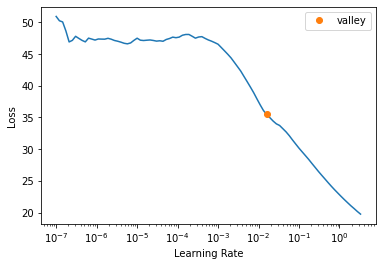

<Figure size 720x720 with 0 Axes>

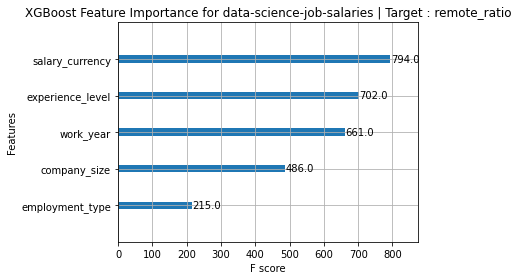

Target Variable: salary_in_usd
CATS=====================
['work_year', 'experience_level', 'employment_type', 'salary_currency', 'remote_ratio', 'company_size']
CONTS=====================
['job_title', 'salary', 'employee_residence', 'company_location']
10
Could not convert job_title to float.
Could not convert employee_residence to float.
Could not convert company_location to float.
Looping through continuous variables to find breakpoint
Error with  job_title
Error with  employee_residence
Error with  company_location
Continuous variables that made the cut : ['salary']
Categorical variables that made the cut : ['work_year', 'experience_level', 'employment_type', 'salary_currency', 'remote_ratio', 'company_size']
Tabular Object size: 565


 17%|█▋        | 7/42 [00:00<00:00, 44.70it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.22354619340966797, 'Adjusted R-Squared': 0.17959597794229065, 'RMSE': 69406.69590916735, 'Time taken': 0.02302861213684082}
{'Model': 'BaggingRegressor', 'R-Squared': 0.37008341507255926, 'Adjusted R-Squared': 0.33442775932194946, 'RMSE': 62515.12158202192, 'Time taken': 0.02903127670288086}
{'Model': 'BayesianRidge', 'R-Squared': 0.221848011706957, 'Adjusted R-Squared': 0.17780167274697345, 'RMSE': 69482.5541280972, 'Time taken': 0.012047529220581055}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.32214999560295887, 'Adjusted R-Squared': 0.2837811274295414, 'RMSE': 64850.05672193196, 'Time taken': 0.010408639907836914}
{'Model': 'DummyRegressor', 'R-Squared': -0.0029570794329074612, 'Adjusted R-Squared': -0.05972823487250589, 'RMSE': 78883.24, 'Time taken': 0.009140253067016602}
{'Model': 'ElasticNet', 'R-Squared': 0.19973549830579462, 'Adjusted R-Squared': 0.15443750764385844, 'RMSE': 70462.87109752247, 'Time taken': 0.0099489688873291

 29%|██▊       | 12/42 [00:00<00:01, 21.10it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.433354080645175, 'Adjusted R-Squared': 0.4012797833232038, 'RMSE': 59292.45620444033, 'Time taken': 0.1430501937866211}
{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.43600433772510183, 'Adjusted R-Squared': 0.4040800549548246, 'RMSE': 59153.63545465241, 'Time taken': 0.1862947940826416}


 43%|████▎     | 18/42 [00:00<00:01, 19.84it/s]

{'Model': 'HuberRegressor', 'R-Squared': 0.20165490762404215, 'Adjusted R-Squared': 0.15646556277257284, 'RMSE': 70378.31887449783, 'Time taken': 0.017810583114624023}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.1557852234481607, 'Adjusted R-Squared': 0.10799948137918869, 'RMSE': 72371.914, 'Time taken': 0.010620355606079102}
{'Model': 'KernelRidge', 'R-Squared': -1.8810074393863707, 'Adjusted R-Squared': -2.0440833321818257, 'RMSE': 133695.17946175294, 'Time taken': 0.03742408752441406}
{'Model': 'Lars', 'R-Squared': 0.22320017684736881, 'Adjusted R-Squared': 0.1792303755368425, 'RMSE': 69422.15928324153, 'Time taken': 0.0415339469909668}
{'Model': 'LarsCV', 'R-Squared': 0.22274813982736685, 'Adjusted R-Squared': 0.17875275151570835, 'RMSE': 69442.35549146423, 'Time taken': 0.03964591026306152}
{'Model': 'Lasso', 'R-Squared': 0.22320006083056498, 'Adjusted R-Squared': 0.17923025295304984, 'RMSE': 69422.16446741928, 'Time taken': 0.019385576248168945}


 50%|█████     | 21/42 [00:00<00:00, 21.90it/s]

{'Model': 'LassoCV', 'R-Squared': 0.22283966028107327, 'Adjusted R-Squared': 0.17884945237245475, 'RMSE': 69438.26699499176, 'Time taken': 0.07109832763671875}
{'Model': 'LassoLars', 'R-Squared': 0.22319759280829343, 'Adjusted R-Squared': 0.17922764523140444, 'RMSE': 69422.27475019824, 'Time taken': 0.011012792587280273}
{'Model': 'LassoLarsCV', 'R-Squared': 0.22274813982736685, 'Adjusted R-Squared': 0.17875275151570835, 'RMSE': 69442.35549146423, 'Time taken': 0.023468971252441406}
{'Model': 'LassoLarsIC', 'R-Squared': 0.22320017684736881, 'Adjusted R-Squared': 0.1792303755368425, 'RMSE': 69422.15928324153, 'Time taken': 0.011970996856689453}
{'Model': 'LinearRegression', 'R-Squared': 0.22320017684736893, 'Adjusted R-Squared': 0.17923037553684262, 'RMSE': 69422.15928324152, 'Time taken': 0.009552240371704102}
{'Model': 'LinearSVR', 'R-Squared': -2.079478849093768, 'Adjusted R-Squared': -2.2537889726273774, 'RMSE': 138223.5909555137, 'Time taken': 0.009366512298583984}


 69%|██████▉   | 29/42 [00:02<00:01, 11.11it/s]

{'Model': 'MLPRegressor', 'R-Squared': -2.0915661030982213, 'Adjusted R-Squared': -2.266560410820762, 'RMSE': 138494.59580517953, 'Time taken': 0.9324817657470703}
{'Model': 'NuSVR', 'R-Squared': -0.010291392276950528, 'Adjusted R-Squared': -0.06747769750017407, 'RMSE': 79171.13755845554, 'Time taken': 0.046999454498291016}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.17526623015822684, 'Adjusted R-Squared': 0.1285831865822774, 'RMSE': 71532.01311969382, 'Time taken': 0.022123336791992188}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.22044551979410942, 'Adjusted R-Squared': 0.17631979449943636, 'RMSE': 69545.14141977463, 'Time taken': 0.0344085693359375}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.20493667062599596, 'Adjusted R-Squared': 0.15993308594444855, 'RMSE': 70233.51757761484, 'Time taken': 0.04289841651916504}
{'Model': 'PoissonRegressor', 'R-Squared': 0.2292945502192617, 'Adjusted R-Squared': 0.1856697134392199, 'RMSE': 69149.29770183437, 'Time 

 76%|███████▌  | 32/42 [00:07<00:05,  1.87it/s]

{'Model': 'QuantileRegressor', 'R-Squared': -0.031758402040692024, 'Adjusted R-Squared': -0.09015982102412745, 'RMSE': 80007.84368753355, 'Time taken': 5.099029302597046}
{'Model': 'RANSACRegressor', 'R-Squared': 0.1130662973581763, 'Adjusted R-Squared': 0.06286250286901651, 'RMSE': 74180.39433728452, 'Time taken': 0.1373121738433838}


 81%|████████  | 34/42 [00:07<00:03,  2.18it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.4124133763979091, 'Adjusted R-Squared': 0.37915375619401714, 'RMSE': 60378.10925587582, 'Time taken': 0.17827963829040527}
{'Model': 'Ridge', 'R-Squared': 0.223145697297623, 'Adjusted R-Squared': 0.17917281223899795, 'RMSE': 69424.5936437789, 'Time taken': 0.011918306350708008}
{'Model': 'RidgeCV', 'R-Squared': 0.22261370357175125, 'Adjusted R-Squared': 0.17861070566071835, 'RMSE': 69448.36073062045, 'Time taken': 0.010307073593139648}
{'Model': 'SGDRegressor', 'R-Squared': 0.223757361280843, 'Adjusted R-Squared': 0.1798190987118341, 'RMSE': 69397.25718870449, 'Time taken': 0.01199483871459961}
{'Model': 'SVR', 'R-Squared': -0.03143679388917886, 'Adjusted R-Squared': -0.08982000863762285, 'RMSE': 79995.3731420382, 'Time taken': 0.025104761123657227}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.22320017684736893, 'Adjusted R-Squared': 0.17923037553684262, 'RMSE': 69422.15928324152, 'Time taken': 0.010599136352539062}
{'Model': 

100%|██████████| 42/42 [00:08<00:00,  5.19it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.32042601068714394, 'Adjusted R-Squared': 0.2819595584618879, 'RMSE': 64932.47, 'Time taken': 0.4136226177215576}
{'Model': 'LGBMRegressor', 'R-Squared': 0.4329281414879881, 'Adjusted R-Squared': 0.40082973440240255, 'RMSE': 59314.73663900925, 'Time taken': 0.06014537811279297}
Project: data-science-job-salaries
data-science-job-salaries
Target: salary_in_usd
salary_in_usd
Target Standard Deviation: 70458.0859375
                               Adjusted R-Squared  R-Squared      RMSE  \
Model                                                                    
HistGradientBoostingRegressor                0.40       0.44  59153.64   
GradientBoostingRegressor                    0.40       0.43  59292.46   
LGBMRegressor                                0.40       0.43  59314.74   
RandomForestRegressor                        0.38       0.41  60378.11   
BaggingRegressor                             0.33       0.37  62515.12   
ExtraTreesRegressor      

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,16976000000.000000,19208118272.000000,138593.359375,00:00
1,16964624384.000000,19205292032.000000,138583.156250,00:00
2,17004793856.000000,19175692288.000000,138476.328125,00:00
3,17001600000.000000,18902704128.000000,137487.109375,00:00
4,16957705216.000000,17031477248.000000,130504.703125,00:00
5,16817629184.000000,12530462720.000000,111939.546875,00:00
6,16533514240.000000,11197522944.000000,105818.351562,00:00
7,16163366912.000000,12659189760.000000,112513.062500,00:00


Better model found at epoch 0 with _rmse value: 138593.359375.
Better model found at epoch 1 with _rmse value: 138583.15625.
Better model found at epoch 2 with _rmse value: 138476.328125.
Better model found at epoch 3 with _rmse value: 137487.109375.
Better model found at epoch 4 with _rmse value: 130504.703125.
Better model found at epoch 5 with _rmse value: 111939.546875.
Better model found at epoch 6 with _rmse value: 105818.3515625.
No improvement since epoch 6: early stopping


,work_year,experience_level,employment_type,salary_currency,remote_ratio,company_size,salary_in_usd,salary_in_usd_pred
0,2.00,3.00,3.00,17.00,1.00,3.00,110000.00,47958.01
1,3.00,4.00,3.00,17.00,3.00,2.00,170000.00,43298.37
2,1.00,1.00,3.00,8.00,1.00,3.00,49268.00,39919.63
3,2.00,4.00,3.00,17.00,3.00,2.00,170000.00,43298.37
4,2.00,2.00,3.00,17.00,3.00,1.00,600000.00,44665.63
5,1.00,4.00,3.00,17.00,2.00,1.00,120000.00,44595.26
6,3.00,1.00,3.00,8.00,3.00,1.00,21983.00,35869.05
7,3.00,4.00,3.00,17.00,3.00,2.00,185100.00,43298.37
8,3.00,3.00,3.00,11.00,3.00,2.00,18442.00,37816.51


<Figure size 432x288 with 0 Axes>

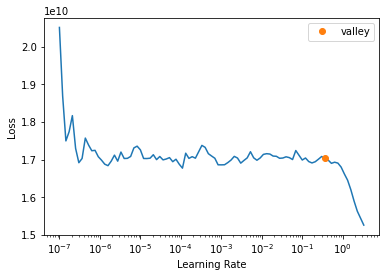

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
     actual  predicted
0 170000.00  141151.44
1 100000.00   68290.23
2 170000.00  150087.09
3  42197.00   63893.66
4 100000.00  141151.44
XGBoost RMSE:  64908.598


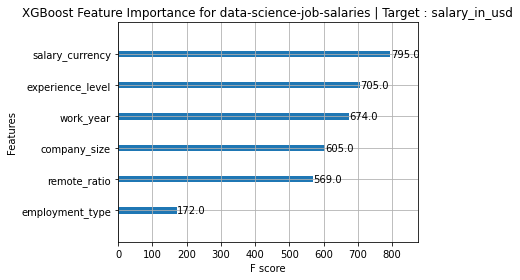

Target Variable: salary
CATS=====================
['work_year', 'experience_level', 'employment_type', 'salary_currency', 'remote_ratio', 'company_size']
CONTS=====================
['job_title', 'salary_in_usd', 'employee_residence', 'company_location']
10
Could not convert job_title to float.
Could not convert employee_residence to float.
Could not convert company_location to float.
Looping through continuous variables to find breakpoint
Error with  job_title
Error with  employee_residence
Error with  company_location
Continuous variables that made the cut : ['salary_in_usd']
Categorical variables that made the cut : ['work_year', 'experience_level', 'employment_type', 'salary_currency', 'remote_ratio', 'company_size']
Tabular Object size: 565


 19%|█▉        | 8/42 [00:00<00:00, 37.94it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.015229654234396373, 'Adjusted R-Squared': -0.040512063450449, 'RMSE': 2864894.2176474435, 'Time taken': 0.06526064872741699}
{'Model': 'BaggingRegressor', 'R-Squared': 0.010223708114634356, 'Adjusted R-Squared': -0.04580136501095233, 'RMSE': 2872166.637332646, 'Time taken': 0.03332090377807617}
{'Model': 'BayesianRidge', 'R-Squared': -0.0024951209140893216, 'Adjusted R-Squared': -0.05924012775828302, 'RMSE': 2890561.6970575824, 'Time taken': 0.013242959976196289}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.01375639651476046, 'Adjusted R-Squared': -0.04206871311647942, 'RMSE': 2867036.4176657647, 'Time taken': 0.012999534606933594}
{'Model': 'DummyRegressor', 'R-Squared': -0.00249513290836223, 'Adjusted R-Squared': -0.05924014043147707, 'RMSE': 2890561.8, 'Time taken': 0.01021575927734375}
{'Model': 'ElasticNet', 'R-Squared': 0.005817017036597094, 'Adjusted R-Squared': -0.05045749143302958, 'RMSE': 2878553.279873364, 'Time taken': 0.01

 29%|██▊       | 12/42 [00:00<00:01, 18.84it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.008747226768477057, 'Adjusted R-Squared': -0.04736142077292982, 'RMSE': 2874308.091001908, 'Time taken': 0.13922643661499023}
{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.009666630903703899, 'Adjusted R-Squared': -0.046389974894199604, 'RMSE': 2872974.7964696726, 'Time taken': 0.1855771541595459}


 43%|████▎     | 18/42 [00:00<00:01, 17.25it/s]

{'Model': 'HuberRegressor', 'R-Squared': -0.01614355834205594, 'Adjusted R-Squared': -0.07366111824821009, 'RMSE': 2910171.906468103, 'Time taken': 0.017833709716796875}
{'Model': 'KNeighborsRegressor', 'R-Squared': -0.04180682068204544, 'Adjusted R-Squared': -0.1007770180791423, 'RMSE': 2946691.8, 'Time taken': 0.012836217880249023}
{'Model': 'KernelRidge', 'R-Squared': -0.013321958974827908, 'Adjusted R-Squared': -0.07067980570925214, 'RMSE': 2906128.655233937, 'Time taken': 0.04600858688354492}
{'Model': 'Lars', 'R-Squared': 0.007319476906401556, 'Adjusted R-Squared': -0.04886998666493425, 'RMSE': 2876377.3494348153, 'Time taken': 0.044194936752319336}
{'Model': 'LarsCV', 'R-Squared': 0.007319476906401556, 'Adjusted R-Squared': -0.04886998666493425, 'RMSE': 2876377.3494348153, 'Time taken': 0.07323193550109863}
{'Model': 'Lasso', 'R-Squared': 0.007319408278346207, 'Adjusted R-Squared': -0.04887005917759635, 'RMSE': 2876377.4488626653, 'Time taken': 0.010958671569824219}


 52%|█████▏    | 22/42 [00:01<00:00, 21.50it/s]

{'Model': 'LassoCV', 'R-Squared': 0.007309319748409204, 'Adjusted R-Squared': -0.04888071875639777, 'RMSE': 2876392.0650174073, 'Time taken': 0.0657050609588623}
{'Model': 'LassoLars', 'R-Squared': 0.007318016880418887, 'Adjusted R-Squared': -0.048871529333897046, 'RMSE': 2876379.4647095813, 'Time taken': 0.010941028594970703}
{'Model': 'LassoLarsCV', 'R-Squared': 0.007319476906401556, 'Adjusted R-Squared': -0.04886998666493425, 'RMSE': 2876377.3494348153, 'Time taken': 0.019495725631713867}
{'Model': 'LassoLarsIC', 'R-Squared': 0.0010041661786248657, 'Adjusted R-Squared': -0.055542767811264326, 'RMSE': 2885512.421913755, 'Time taken': 0.012247800827026367}
{'Model': 'LinearRegression', 'R-Squared': 0.007319476906401556, 'Adjusted R-Squared': -0.04886998666493425, 'RMSE': 2876377.3494348153, 'Time taken': 0.009460687637329102}
{'Model': 'LinearSVR', 'R-Squared': -0.02462478885640862, 'Adjusted R-Squared': -0.0826224184143185, 'RMSE': 2922291.528108422, 'Time taken': 0.00989794731140136

 69%|██████▉   | 29/42 [00:02<00:01, 10.41it/s]

{'Model': 'MLPRegressor', 'R-Squared': -0.02465781366247244, 'Adjusted R-Squared': -0.08265731254902753, 'RMSE': 2922338.622095606, 'Time taken': 0.977785587310791}
{'Model': 'NuSVR', 'R-Squared': -0.013543038457256351, 'Adjusted R-Squared': -0.07091339912464822, 'RMSE': 2906445.657334731, 'Time taken': 0.04791069030761719}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': -0.002577211387309486, 'Adjusted R-Squared': -0.059326864862062845, 'RMSE': 2890680.0431298926, 'Time taken': 0.022602319717407227}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': -0.002577211387309486, 'Adjusted R-Squared': -0.059326864862062845, 'RMSE': 2890680.0431298926, 'Time taken': 0.03434109687805176}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -0.017064540977122844, 'Adjusted R-Squared': -0.07463423197582797, 'RMSE': 2911490.4262478733, 'Time taken': 0.04413652420043945}
{'Model': 'PoissonRegressor', 'R-Squared': 0.004620382533955358, 'Adjusted R-Squared': -0.05172185996412271, 'RMSE': 28802

 76%|███████▌  | 32/42 [00:07<00:06,  1.66it/s]

{'Model': 'QuantileRegressor', 'R-Squared': -0.013910813130050048, 'Adjusted R-Squared': -0.07130199123175096, 'RMSE': 2906972.926582666, 'Time taken': 5.636316537857056}
{'Model': 'RANSACRegressor', 'R-Squared': -0.01817842244878798, 'Adjusted R-Squared': -0.07581116334211568, 'RMSE': 2913084.3112244643, 'Time taken': 0.13789916038513184}


 81%|████████  | 34/42 [00:08<00:04,  1.97it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.011714050164046919, 'Adjusted R-Squared': -0.04422666397761077, 'RMSE': 2870003.4600106846, 'Time taken': 0.17639970779418945}
{'Model': 'Ridge', 'R-Squared': 0.007314484737607652, 'Adjusted R-Squared': -0.04887526140932019, 'RMSE': 2876384.5820453363, 'Time taken': 0.011912345886230469}
{'Model': 'RidgeCV', 'R-Squared': 0.007267664533406437, 'Adjusted R-Squared': -0.048924731813759115, 'RMSE': 2876452.413862911, 'Time taken': 0.009844779968261719}
{'Model': 'SGDRegressor', 'R-Squared': 0.006876395565832083, 'Adjusted R-Squared': -0.049338148081385036, 'RMSE': 2877019.2110004188, 'Time taken': 0.009833335876464844}
{'Model': 'SVR', 'R-Squared': -0.013917104485757115, 'Adjusted R-Squared': -0.07130863870193194, 'RMSE': 2906981.9455082486, 'Time taken': 0.024556875228881836}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.007319476906401556, 'Adjusted R-Squared': -0.04886998666493425, 'RMSE': 2876377.3494348153, 'Time taken': 0.010

100%|██████████| 42/42 [00:08<00:00,  4.80it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.020020055639877632, 'Adjusted R-Squared': -0.03545050724843124, 'RMSE': 2857917.5, 'Time taken': 0.4256722927093506}
{'Model': 'LGBMRegressor', 'R-Squared': -0.0014665679071068638, 'Adjusted R-Squared': -0.058153354769773236, 'RMSE': 2889078.468436954, 'Time taken': 0.05328512191772461}
Project: data-science-job-salaries
data-science-job-salaries
Target: salary
salary
Target Standard Deviation: 1051691.625
                               Adjusted R-Squared  R-Squared       RMSE  \
Model                                                                     
XGBRegressor                                -0.04       0.02 2857917.50   
AdaBoostRegressor                           -0.04       0.02 2864894.22   
DecisionTreeRegressor                       -0.04       0.01 2867036.42   
RandomForestRegressor                       -0.04       0.01 2870003.46   
BaggingRegressor                            -0.05       0.01 2872166.64   
HistGradientBoostingRegr

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,1213311090688.000000,8540196438016.000000,2922361.250000,00:00
1,1193406496768.000000,8540190670848.000000,2922360.500000,00:00
2,1217258848256.000000,8540156592128.000000,2922354.750000,00:00
3,1221554601984.000000,8539914371072.000000,2922313.000000,00:00
4,1211733901312.000000,8538220920832.000000,2922023.250000,00:00
5,1178893680640.000000,8536222334976.000000,2921681.500000,00:00
6,1182260002816.000000,8533474017280.000000,2921211.250000,00:00
7,1189324128256.000000,8524153749504.000000,2919615.250000,00:00
8,1196735856640.000000,8523316461568.000000,2919471.750000,00:00
9,1195955585024.000000,8525976698880.000000,2919927.500000,00:00


Better model found at epoch 0 with _rmse value: 2922361.25.
Better model found at epoch 1 with _rmse value: 2922360.5.
Better model found at epoch 2 with _rmse value: 2922354.75.
Better model found at epoch 3 with _rmse value: 2922313.0.
Better model found at epoch 4 with _rmse value: 2922023.25.
Better model found at epoch 5 with _rmse value: 2921681.5.
Better model found at epoch 6 with _rmse value: 2921211.25.
Better model found at epoch 7 with _rmse value: 2919615.25.
Better model found at epoch 8 with _rmse value: 2919471.75.
No improvement since epoch 8: early stopping


,work_year,experience_level,employment_type,salary_currency,remote_ratio,company_size,salary,salary_pred
0,1.00,3.00,3.00,8.00,2.00,1.00,61500.00,6369.11
1,1.00,1.00,3.00,17.00,3.00,1.00,91000.00,16698.88
2,2.00,4.00,3.00,17.00,3.00,1.00,55000.00,11210.24
3,3.00,3.00,3.00,9.00,1.00,2.00,90000.00,14509.92
4,3.00,3.00,3.00,17.00,3.00,2.00,120000.00,9111.66
5,2.00,1.00,3.00,17.00,2.00,3.00,81000.00,7114.09
6,3.00,4.00,3.00,17.00,3.00,2.00,69000.00,7126.82
7,3.00,4.00,3.00,17.00,3.00,2.00,145000.00,7126.82
8,3.00,1.00,3.00,17.00,1.00,2.00,125000.00,10471.06


<Figure size 432x288 with 0 Axes>

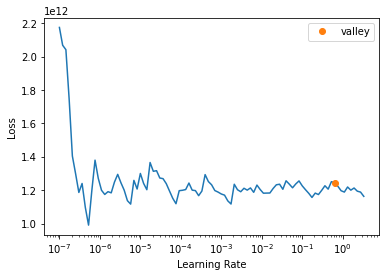

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
     actual  predicted
0 144000.00  178067.73
1  50000.00  130476.34
2  39600.00   59188.29
3  85000.00   13203.57
4  21000.00   49350.44
XGBoost RMSE:  2857917.5


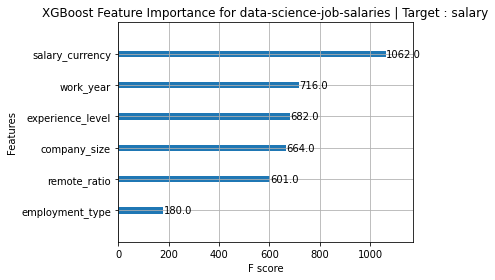

<Figure size 432x288 with 0 Axes>

In [19]:

if SEP_DOLLAR:
    #For every column in df, if the column contains a $, make a new column with the value without the $
    for col in df.columns:
        if '$' in df[col].to_string():
            df[col + '_no_dollar'] = df[col].str.replace('$', '').str.replace(',', '')


if SEP_PERCENT:
    #For every column in df, if the column contains a %, make a new column with the value without the %
    for col in df.columns:
        if '%' in df[col].to_string():
            df[col + '_no_percent'] = df[col].str.replace('%', '').str.replace(',', '')

target = ''
target_str = ''
#The column closest to the end isPARAM_DIR the target variable that can be represented as a float is the target variable
targets = []
#Loop through every possible target column (Continuous)
for i in range(len(df.columns)-1, 0, -1):
    try:
        df[df.columns[i]] = df[df.columns[i]].astype(float)
        target = df.columns[i]
        target_str = target.replace('/', '-')
    except:
        continue
    print(f'Target Variable: {target}')
    #Will be determined by the file name


    #===================================================================================================

    #Create project config files if they don't exist.
    if not os.path.exists(param_dir):
        #create param_dir
        os.makedirs(PARAM_DIR)
    if not os.path.exists(f'{PARAM_DIR}/cats.txt'):
        #create param_dir
        with open(f'{PARAM_DIR}/cats.txt', 'w') as f:
            f.write('')
    if not os.path.exists(f'{PARAM_DIR}/conts.txt'):
        #create param_dir
        with open(f'{PARAM_DIR}/conts.txt', 'w') as f:
            f.write('')
    if not os.path.exists(f'{PARAM_DIR}/cols_to_delete.txt'):
        with open(f'{PARAM_DIR}/cols_to_delete.txt', 'w') as f:
            f.write('')

    df = df.drop_duplicates()
    if SHUFFLE_DATA:
        df = df.sample(frac=1).reset_index(drop=True)

    # workaround for fastai/pytorch bug where bool is treated as object and thus erroring out.
    for n in df:
        if pd.api.types.is_bool_dtype(df[n]):
            df[n] = df[n].astype('uint8')

    with open(f'{PARAM_DIR}/cols_to_delete.txt', 'r') as f:
        cols_to_delete = f.read().splitlines()
    for col in cols_to_delete:
        try:
            del(df[col])
        except:
            pass
    #try to fill in missing values now, otherwise FastAI will do it for us later
    try:
        df = df.fillna(0)
    except:
        pass
    #print missing values
    #print(df.isna().sum().sort_values(ascending=False))
    #shrink df as much as possible
    df = df_shrink(df)


    #print types inside of df
    #print(df.dtypes)


    #Auto detect categorical and continuous variables
    #==============================================================================
    likely_cat = {}
    for var in df.columns:
        likely_cat[var] = 1.*df[var].nunique()/df[var].count() < 0.05 #or some other threshold

    cats = [var for var in df.columns if likely_cat[var]]
    conts = [var for var in df.columns if not likely_cat[var]]

    #remove target from lists
    try:
        conts.remove(target)
        cats.remove(target)
    except:
        pass
    #Convert target to float
    df[target] = df[target].astype(float)

    print('CATS=====================')
    print(cats)
    print('CONTS=====================')
    print(conts)

    #Populate categorical and continuous lists
    #==============================================================================

    if VARIABLE_FILES == True:
        with open(f'{PARAM_DIR}/cats.txt', 'r') as f:
            cats = f.read().splitlines()

        with open(f'{PARAM_DIR}/conts.txt', 'r') as f:
            conts = f.read().splitlines()

    #==============================================================================

    #==============================================================================
    procs = [Categorify, FillMissing, Normalize]
    #print(df.describe().T)
    df = df[0:SAMPLE_COUNT]
    splits = RandomSplitter()(range_of(df))

    print((len(cats)) + len(conts))
    #conts = []

    #Convert cont variables to floats
    #==============================================================================

    #Convert cont variables to floats
    #==============================================================================

    for var in conts:
        try:
            df[var] = df[var].astype(float)
        except:
            print(f'Could not convert {var} to float.')
            pass

    #==============================================================================

    #Experimental logic to add columns one-by-one to find a breakpoint
    #==============================================================================
    if ENABLE_BREAKPOINT == True:
        temp_procs = [Categorify, FillMissing]
        print('Looping through continuous variables to find breakpoint')
        cont_list = []
        for cont in conts:
            focus_cont = cont
            cont_list.append(cont)
            #print(focus_cont)
            try:
                to = TabularPandas(df, procs=procs, cat_names=cats, cont_names=cont_list, y_names=target, y_block=RegressionBlock(), splits=splits)
                del(to)
            except:
                print('Error with ', focus_cont)
                #remove focus_cont from list
                cont_list.remove(focus_cont)
                #traceback.print_exc()
                continue
        #convert all continuous variables to floats
        for var in cont_list:
            try:
                df[var] = df[var].astype(float)
            except:
                print(f'Could not convert {var} to float.')
                cont_list.remove(var)
                if CONVERT_TO_CAT == True:
                    cats.append(var)
                pass
        print(f'Continuous variables that made the cut : {cont_list}')
        print(f'Categorical variables that made the cut : {cats}')
        #shrink df as much as possible
        df = df_shrink(df)
        #print(df.dtypes)

    #==============================================================================

    #Creating tabular object + quick preprocessing
    #==============================================================================
    to = None
    if REGRESSOR == True:
        try:
            to = TabularPandas(df, procs, cats, conts, target, y_block=RegressionBlock(), splits=splits)
        except:
            conts = []
            to = TabularPandas(df, procs, cats, conts, target, y_block=RegressionBlock(), splits=splits)
    else:
        try:
            to = TabularPandas(df, procs, cats, conts, target, splits=splits)
        except:
            conts = []
            to = TabularPandas(df, procs, cats, conts, target, splits=splits)

    #print(dir(to))
    #print(to.xs)
    dls = to.dataloaders()
    print(f'Tabular Object size: {len(to)}')
    try:
        dls.one_batch()
    except:
        print(f'problem with getting one batch of {PROJECT_NAME}')
    #==============================================================================

    #Extracting train and test sets from tabular object
    #==============================================================================

    X_train, y_train = to.train.xs, to.train.ys.values.ravel()
    X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

    #Make sure target isn't in independent columns
    if target in X_train and target in X_test:
        del(X_train[target])
        del(X_test[target])
    #create dataframe from X_train and y_train
    #export tabular object to csv
    pd.DataFrame(X_train).to_csv(f'{PARAM_DIR}/X_train_{target_str}.csv', index=False)
    pd.DataFrame(X_test).to_csv(f'{PARAM_DIR}/X_test_{target_str}.csv', index=False)
    pd.DataFrame(y_train).to_csv(f'{PARAM_DIR}/y_train_{target_str}.csv', index=False)
    pd.DataFrame(y_test).to_csv(f'{PARAM_DIR}/y_test_{target_str}.csv', index=False)

    #==============================================================================

    #==============================================================================

    #Ready for model selection!

    if REGRESSOR == True:
        try:
            reg = LazyRegressor(verbose=2, ignore_warnings=False, custom_metric=None)
            models, predictions = reg.fit(X_train, X_test, y_train, y_test)
            print(f'Project: {PROJECT_NAME}')
            print(PROJECT_NAME)
            print(f'Target: {target}')
            print(target)
            target_std = y_train.std()
            print(f'Target Standard Deviation: {target_std}')
            print(models)
            models['project'] = PROJECT_NAME
            models['target'] = target
            models['target_std'] = target_std
            #rename index of 
            models.to_csv(f'{PARAM_DIR}/regression_results_{target_str}.csv', mode='a', header=True, index=True)
        except:
            print('Issue during lazypredict analysis')
    else:
        #TODO: remove this
        try:
            clf = LazyClassifier(verbose=2, ignore_warnings=False, custom_metric=None)
            models, predictions = clf.fit(X_train, X_test, y_train, y_test)
            print(f'Project: {PROJECT_NAME}')
            print(PROJECT_NAME)
            print(f'Target: {target}')
            print(target)
            print(f'Target Standard Deviation: {y_train.std()}')
            print(models)
            models.to_csv(f'{PARAM_DIR}/classification_results.csv', mode='a', header=False)
        except:
            print('Issue during lazypredict analysis')

    model_name = 'tabnet'

    # FastAI + pre-trained TabNet
    #==============================================================================
    learn = None
    i = 0
    while True:
        try:
            del learn
        except:
            pass
        try:
            learn = 0
            model = TabNetModel(get_emb_sz(to), len(to.cont_names), dls.c, n_d=64, n_a=64, n_steps=5, virtual_batch_size=256)
            # save the best model so far, determined by early stopping
            cbs = [SaveModelCallback(monitor='_rmse', comp=np.less, fname=f'{model_name}_{PROJECT_NAME}_{target_str}_best'), EarlyStoppingCallback()]
            learn = Learner(dls, model, loss_func=MSELossFlat(), metrics=rmse, cbs=cbs)
            #learn = get_learner(to)
            if(learn != 0):
                break
            if i > 50:
                break
        except:
            i += 1
            print('Error in FastAI TabNet')
            traceback.print_exc()
            continue
    try:
        #display learning rate finder results
        x = learn.lr_find()
    except:
        pass
    if AUTO_ADJUST_LEARNING_RATE == True:
        FASTAI_LEARNING_RATE = x.valley
    print(f'LEARNING RATE: {FASTAI_LEARNING_RATE}')
    try:
        if i < 50:
            learn.fit_one_cycle(20, FASTAI_LEARNING_RATE)
            plt.figure(figsize=(10, 10))
            try:
                ax = learn.show_results()
                plt.show(block=True)
            except:
                print('Could not show results')
                pass
    except:
        print('Could not fit model')
        traceback.print_exc()
        pass

    #==============================================================================

    #fit an xgboost model
    #==============================================================================
    if REGRESSOR == True:
        xgb = XGBRegressor()
    else:
        xgb = XGBClassifier()
    try:
        xgb = XGBRegressor()
        xgb.fit(X_train, y_train)
        y_pred = xgb.predict(X_test)
        print('XGBoost Predictions vs Actual==========')
        print(pd.DataFrame({'actual': y_test, 'predicted': y_pred}).head())
        print('XGBoost RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred)))
        #save feature importance plot to file
        plot_importance(xgb)
        plt.title(f'XGBoost Feature Importance for {PROJECT_NAME} | Target : {target}', wrap=True)
        plt.tight_layout()
        plt.show()
        plt.savefig(f'{PARAM_DIR}/xgb_feature_importance_{target_str}.png')
        fi_df = pd.DataFrame([xgb.get_booster().get_score()]).T
        fi_df.columns = ['importance']
        #create a column based off the index called feature
        fi_df['feature'] = fi_df.index
        #create a dataframe of feature importance
        fi_df = fi_df[['feature', 'importance']]
        fi_df.to_csv(f'{PARAM_DIR}/xgb_feature_importance_{target_str}.csv', index=False)
        #xgb_fi = pd.DataFrame(xgb.feature_importances_, index=X_train.columns, columns=['importance'])
        #xgb_fi.to_csv(f'{PARAM_DIR}/xgb_feature_importance_{target_str}.csv')
        #print('XGBoost AUC: ', roc_auc_score(y_test, y_pred))
    except:
        traceback.print_exc()
        print('XGBoost failed')

# <div style="text-align: center; background-color: blue; color: white; padding: 14px; line-height: 1;border-radius:20px">**Overall Feature Importance**</div>

            feature  importance
0         work_year      716.00
1  experience_level      682.00
2   employment_type      180.00
3   salary_currency     1062.00
4      remote_ratio      601.00


<AxesSubplot:title={'center':'XGBoost Overall Feature Importance'}, xlabel='feature'>

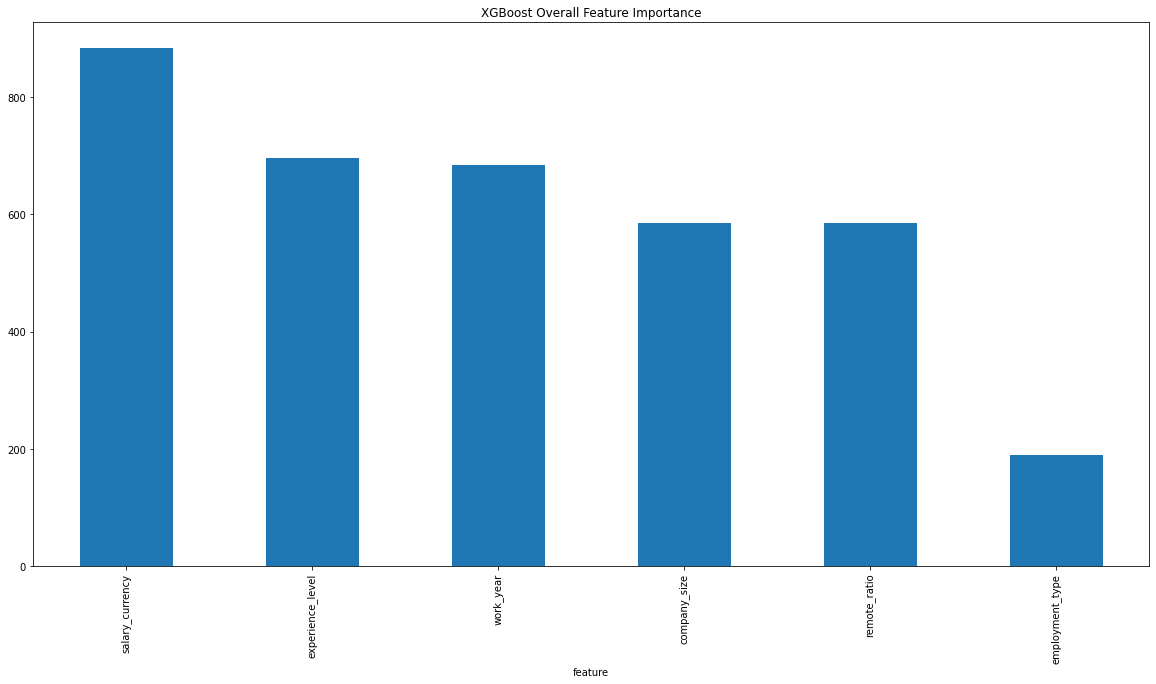

In [20]:
out_dir = f'./{PROJECT_NAME}'
xgb_feature_importance_csvs = []

for file in os.listdir(out_dir):
    if 'xgb_feature_importance' in file and '.csv' in file:
        xgb_feature_importance_csvs.append(pd.read_csv(os.path.join(out_dir, file)))

xgb_feature_importance = pd.concat(xgb_feature_importance_csvs,axis=0)
xgb_feature_importance.rename(columns={'Unnamed: 0': 'feature'}, inplace=True)
print(xgb_feature_importance.head())
xgb_feature_importance.groupby('feature')['importance'].mean().sort_values(ascending=False).plot(kind='bar', title='XGBoost Overall Feature Importance', figsize=(20, 10))

In [21]:
df.isna().sum()

work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64

# **To Be Continued...**